### Compile a Synthetic B-Field and estimate induced E-field on a 1000 km long submarine cable segment located under a sea with water depth 4 km with sea resistivity $\rho_s=0.3 \Omega m$.
---
* __author__ = Chakraborty, S.
* __copyright__ = 
* __credits__ = []
* __license__ = MIT
* __version__ = 1.0
* __maintainer__ = Chakraborty, S.
* __email__ = shibaji7@vt.edu
* __status__ = Research

> Parameters for this simulation are described in the input control json object 'ICJ' 

In [1]:
# Import all required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace
plt.style.use(["science", "ieee"])
from gic.model.oml import OceanModel
from gic.model.cables import Cable, TheoriticalSolver
from gic.model.utils import RecursiveNamespace, frexp102str, fft
from gic.validation import SytheticCableAnalysis as SCA

from scipy.stats import pearsonr

In [2]:
#!python simulate.py
ICJ = {
  "sid": 1,
  "opcode": 0,
  "Bfield": {
    "structure": { # Describe synthetic B-field structure
      "Am": [ # Magnitudes of different phase components
        200, 
        90,
        30,
        17,
        8,
        3.5
      ],
      "Tm_min": [ # Periods (frequency)) of different phase components
        180,
        80,
        36,
        15,
        8,
        3
      ],
      "Phim": [ # Phase (lag/lead) of different phase components
        10,
        20,
        30,
        40,
        50,
        60
      ],
      "T_hours": 72 # Time series of B-field length
    },
    "tapering": 0.0 # Tapering coefficient
  },
  "cable": { # Cable description
    "cable_sections": [ # Description of cable sections
      {
        "sec_id": None,
        "len_km": 1000, # Length of the cable
        "elec_params": {
          "earth_model": "FT1", # Earth model stored in 'config/conductivity.json'
          "ocean_depth": 4000, # Ocean depth in meters
          "ocean_resistivity": 0.3 # Ocean resistivity
        }
      }
    ],
    "cable_pot_plot_index": 0
  },
  "out_dir": "tmp/out/001/", # Output directory
  "opname": "Synthetic-B"
}

control = RecursiveNamespace(**ICJ) # Convert dictionary to object
synb = SCA(control.Bfield, control.cable, out_dir=control.out_dir) # Call cable analysis
synb.run() # 

2022-09-15 22:46:47.561 | INFO     | gic.validation.simulate_synB_synT:__init__:52 - Synthetic B-field run parameters
2022-09-15 22:46:47.561 | INFO     | gic.model.synthetic:__init__:105 - Creating B-field data
2022-09-15 22:46:47.638 | INFO     | gic.model.oml:__init__:63 - Compile OM[FT1] to calc O(floor) E- and B-Fields
2022-09-15 22:46:47.641 | INFO     | gic.validation.simulate_synB_synT:run:98 - Synthetic B FT1->OM(FT1)
2022-09-15 22:46:48.091 | INFO     | gic.validation.simulate_synB_synT:check_analytical_numerical:226 - Corr(Eanl,Enum): 1.0000000000


In [3]:
%matplotlib inline
# Synthetic B-field plot
Bt = synb.ds.field["syn"]
Bt.head()

,X,dTime
0,-20.734236,0.0
1,-20.216802,1.0
2,-19.704925,2.0
3,-19.198687,3.0
4,-18.698168,4.0


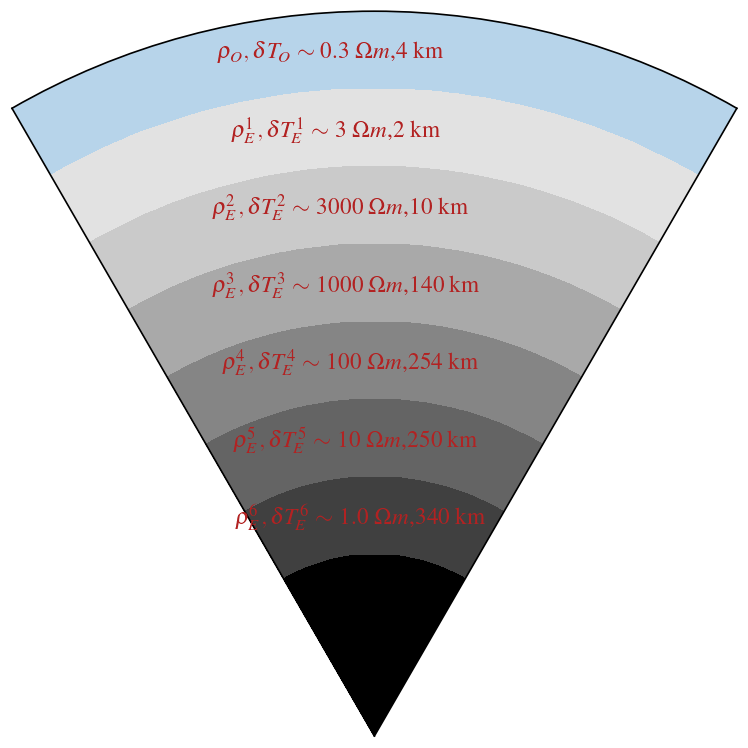

In [12]:
oml = synb.ocean_model_list[0]
fig = plt.figure(dpi=240, figsize=(4, 4))
ax = fig.add_subplot(111, projection="polar")
oml.plot_earth_interior(ax, params={"thick":3.})

In [5]:
# E-field
Et = pd.read_csv("tmp/out/001/Eanl_FT1_h-4000.r-0.30_syn.csv")
Et.head()

,dTime,X
0,0,7.53681
1,1,7.56714
2,2,7.59723
3,3,7.62708
4,4,7.65669


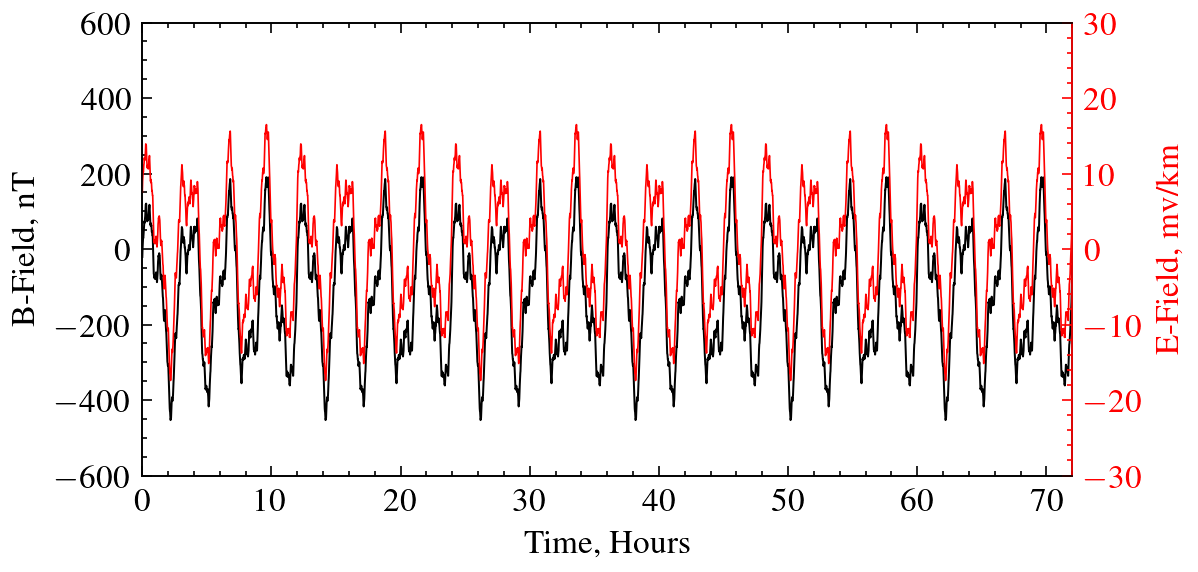

In [6]:
# Plot B and induced E-fields from 1D calculation
fig = plt.figure(dpi=240, figsize=(5,2.5))
ax = fig.add_subplot(111)
ax.plot(Bt.dTime / 3600.0, Bt.X, ls="-", lw=0.6)
ax.set_xlabel("Time, Hours")
ax.set_ylabel("B-Field, nT")
ax.set_xlim(0, 72)
_ = ax.set_ylim(-600, 600)
ax = ax.twinx()
ax.plot(Et.dTime / 3600.0, Et.X, ls="-", lw=0.5, color="r")
ax.set_ylabel("E-Field, mv/km", color="r")
ax.set_xlim(0, 72)
ax.spines["right"].set_color("red")
ax.tick_params(axis="y", colors="red", which="both")
_ = ax.set_ylim(-30, 30)

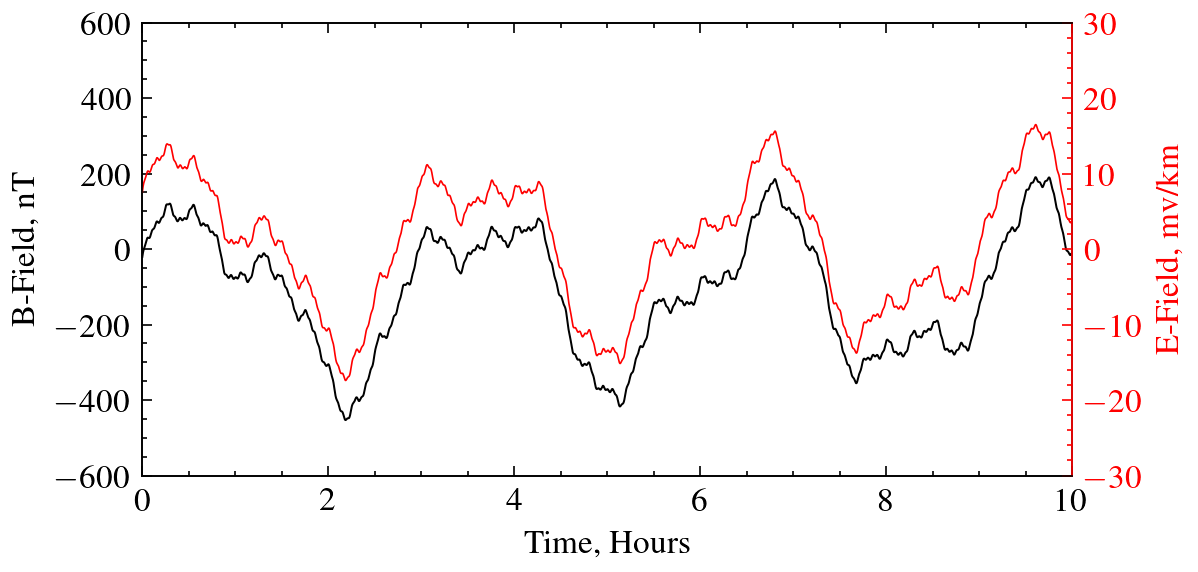

In [7]:
# Plot B and induced E-fields from 1D calculation
fig = plt.figure(dpi=240, figsize=(5,2.5))
ax = fig.add_subplot(111)
ax.plot(Bt.dTime / 3600.0, Bt.X, ls="-", lw=0.6)
ax.set_xlabel("Time, Hours")
ax.set_ylabel("B-Field, nT")
ax.set_xlim(0, 1)
_ = ax.set_ylim(-600, 600)
ax = ax.twinx()
ax.plot(Et.dTime / 3600.0, Et.X, ls="-", lw=0.5, color="r")
ax.set_ylabel("E-Field, mv/km", color="r")
ax.set_xlim(0, 10)
ax.spines["right"].set_color("red")
ax.tick_params(axis="y", colors="red", which="both")
_ = ax.set_ylim(-30, 30)

In [8]:
Tf = synb.draw_TF_table(synb.ocean_model_list[0])
Ea, Th, m = [], [], 0
for A, P, T in zip(control.Bfield.structure.Am, control.Bfield.structure.Phim, control.Bfield.structure.Tm_min):
    Th.append(P + Tf["Phase (deg)"][m])
    Ea.append(A*np.absolute(Tf["Amplitude (mV/km/nT)"])[m])
    m += 1
print(np.array(Ea).round(2), np.array(Th).round(2))

[10.35  4.86  1.65  0.95  0.45  0.19] [20.66 25.   31.22 36.88 41.93 36.37]


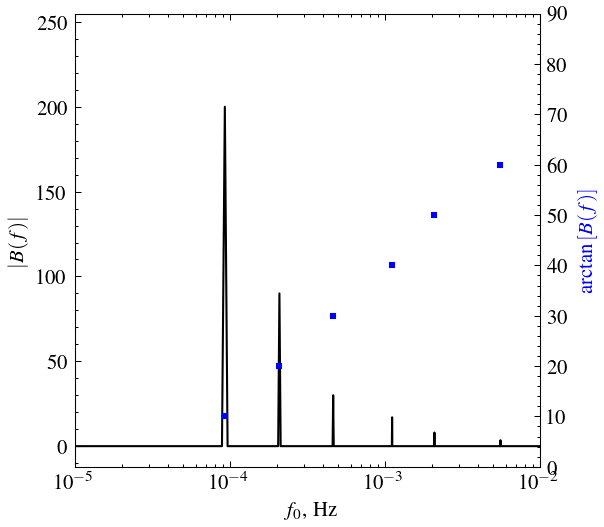

In [9]:
from gic.model import utils
Bf, f = utils.fft(Bt.X, 1.0)

f0 = 1./(np.array([180, 80, 36, 15, 8, 3])*60)
Bf0 = [Bf[np.argmin(np.abs(f-tf))] for tf in f0]

fig = plt.figure(figsize=(4,4), dpi=150)
ax = fig.add_subplot(111)
ax.semilogx(f, np.absolute(Bf))
ax.set_ylabel(r"$|B(f)|$")
ax.set_xlabel(r"$f_0$, Hz")
ax.set_xlim(1e-5, 1e-2)
ax = ax.twinx()
ax.set_ylabel(r"$\arctan{[B(f)]}$", color="b")
ax.semilogx(f0, 90+np.angle(Bf0, deg=True), 'bs', ms=1.5)
ax.set_ylim(0, 90)
_ = ax.set_xlim(1e-5, 1e-2)

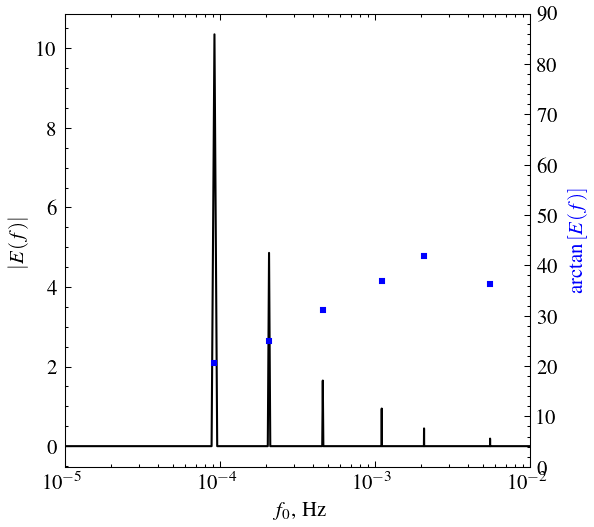

In [10]:
Ef, f = utils.fft(Et.X, 1.0)

f0 = 1./(np.array([180, 80, 36, 15, 8, 3])*60)
Ef0 = [Ef[np.argmin(np.abs(f-tf))] for tf in f0]

fig = plt.figure(figsize=(4,4), dpi=150)
ax = fig.add_subplot(111)
ax.semilogx(f, np.absolute(Ef))
ax.set_ylabel(r"$|E(f)|$")
ax.set_xlabel(r"$f_0$, Hz")
#ax.set_xlim(1e-5, 1e-2)
ax = ax.twinx()
ax.set_ylabel(r"$\arctan{[E(f)]}$", color="b")
ax.semilogx(f0, 90+np.angle(Ef0, deg=True), 'bs', ms=1.5)
ax.set_ylim(0, 90)
_ = ax.set_xlim(1e-5, 1e-2)